In [2]:
import torch, shutil, os

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# Check free disk in current folder
st = shutil.disk_usage(os.getcwd())
print("Disk free (GB):", st.free // (1024**3))


Torch version: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 3050 Laptop GPU
Disk free (GB): 35


In [5]:
# === IDD-Lite Segmentation Visualization (Windows path updated) ===

from pathlib import Path
import random, cv2, numpy as np
import matplotlib.pyplot as plt

# --- Your exact dataset path ---
data_root = Path("E:/projects/adas_local/data/idd_lite/idd-lite/idd20k_lite")

print("Using dataset root:", data_root)

left_img = data_root / "leftImg8bit"
gt_fine  = data_root / "gtFine"

if not left_img.exists() or not gt_fine.exists():
    raise SystemExit("ERROR: Could not find leftImg8bit or gtFine folders at the path above.")

# Count train/val/test
subsets = ["train", "val", "test"]
for s in subsets:
    img_count = len(list((left_img / s).rglob("*.png")))
    mask_count = len(list((gt_fine / s).rglob("*.png")))
    print(f"{s.upper()}: {img_count} images, {mask_count} masks")

# Function to find masks for each image
def find_mask(img_path):
    img_stem = img_path.stem.replace("_leftImg8bit", "")
    split = img_path.parts[-3]  # train/val/test
    city  = img_path.parts[-2]
    mask_dir = gt_fine / split / city
    
    candidates = list(mask_dir.glob(f"{img_stem}*labelIds.png"))
    if not candidates:
        candidates = list(mask_dir.glob(f"{img_stem}*.png"))
    return candidates[0] if candidates else None

# Sample visualization
samples = []
for s in ("train", "val"):
    imgs = list((left_img / s).rglob("*.png"))
    if imgs:
        samples.extend(random.sample(imgs, min(2, len(imgs))))

samples = samples[:4]
print("Selected images:", [s.name for s in samples])

# Random color map for segmentation overlay
np.random.seed(42)
cmap = np.random.randint(0, 255, (256, 3), dtype=np.uint8)

# Show images + masks
for img_p in samples:
    img = cv2.cvtColor(cv2.imread(str(img_p)), cv2.COLOR_BGR2RGB)
    mask_p = find_mask(img_p)

    if mask_p is None:
        print("Mask not found for:", img_p.name)
        overlay = img.copy()
    else:
        mask = cv2.imread(str(mask_p), cv2.IMREAD_UNCHANGED)
        if mask.ndim == 3:
            mask = mask[:, :, 0]     # convert RGB mask → label IDs
        if mask.shape != img.shape[:2]:
            mask = cv2.resize(mask, (img.shape[1], img.shape[0]), cv2.INTER_NEAREST)

        col = cmap[mask % 256]
        overlay = (0.5 * img + 0.5 * col).astype(np.uint8)

    # Plot
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title(f"Image: {img_p.name}")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(overlay)
    plt.title(f"Mask Overlay: {mask_p.name if mask_p else 'NOT FOUND'}")
    plt.axis("off")

plt.show()


Using dataset root: E:\projects\adas_local\data\idd_lite\idd-lite\idd20k_lite
TRAIN: 0 images, 2806 masks
VAL: 0 images, 408 masks
TEST: 0 images, 0 masks
Selected images: []


In [6]:
# Inspect exact file layout & sample filenames in your IDD-lite root
from pathlib import Path
from collections import Counter
import os, itertools, textwrap

data_root = Path(r"E:\projects\adas_local\data\idd_lite\idd-lite\idd20k_lite")
left_img = data_root / "leftImg8bit"
gt_fine  = data_root / "gtFine"

def sample_tree(root, depth=2):
    if not root.exists():
        return f"Missing: {root}"
    out = []
    for p in sorted(root.iterdir()):
        out.append(str(p.name))
        if depth > 0 and p.is_dir():
            children = [str(c.name) for c in sorted(p.iterdir())][:50]
            out.append("  children: " + ", ".join(children))
    return "\n".join(out)

print("LEFT IMG tree (2 levels):")
print(sample_tree(left_img, depth=2))
print("\nGT FINE tree (2 levels):")
print(sample_tree(gt_fine, depth=2))

# Count file extensions under leftImg8bit and gtFine (recursively)
def ext_counts(path):
    exts = Counter()
    files = list(path.rglob("*"))
    for f in files:
        if f.is_file():
            exts[f.suffix.lower()] += 1
    return exts, files[:20]

li_exts, li_samples = ext_counts(left_img) if left_img.exists() else (None, [])
gt_exts, gt_samples = ext_counts(gt_fine) if gt_fine.exists() else (None, [])

print("\nFile extension counts under leftImg8bit:", li_exts)
print("Sample leftImg8bit files (up to 20):")
for p in li_samples[:20]:
    print(" ", p.relative_to(data_root))

print("\nFile extension counts under gtFine:", gt_exts)
print("Sample gtFine files (up to 20):")
for p in gt_samples[:20]:
    print(" ", p.relative_to(data_root))

# If leftImg8bit has 0 images but gtFine has masks, try searching entire data_root for any image files:
all_img_exts = [".png", ".jpg", ".jpeg", ".bmp", ".tif"]
found_imgs = []
for ext in all_img_exts:
    found_imgs.extend(list(data_root.rglob(f"*{ext}")))
print(f"\nTotal image files found in entire root for common extensions: {len(found_imgs)}")
if found_imgs:
    print("First 20 image paths found:")
    for p in found_imgs[:20]:
        print(" ", p.relative_to(data_root))

# Print a few mask filenames to compare stems
print("\nFirst 20 mask filenames (gtFine) for stem inspection:")
masks = list(data_root.rglob("*_gtFine_labelIds.png")) + list(data_root.rglob("*_gtFine_color.png")) + list(data_root.rglob("*labelTrainIds.png"))
for m in masks[:20]:
    print(" ", m.relative_to(data_root))


LEFT IMG tree (2 levels):
test
  children: 103, 105, 109, 111, 112, 113, 114, 12, 120, 123, 129, 13, 134, 14, 15, 159, 161, 165, 169, 179, 180, 19, 200, 208, 210, 22, 226, 228, 229, 232, 244, 249, 251, 253, 254, 256, 259, 27, 271, 281, 297, 300, 304, 323, 324, 33, 332, 335, 343, 344
train
  children: 0, 1, 10, 100, 101, 102, 104, 106, 108, 11, 110, 115, 116, 117, 118, 121, 122, 124, 125, 126, 127, 128, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 151, 152, 154, 155, 156, 157, 158, 16, 160, 162, 163, 164, 166
val
  children: 119, 132, 147, 148, 149, 150, 153, 167, 17, 172, 18, 181, 205, 21, 212, 215, 222, 227, 234, 24, 240, 272, 276, 279, 286, 289, 291, 292, 3, 319, 328, 330, 341, 342, 346, 349, 378, 379, 385, 388, 412, 415, 418, 420, 461, 47, 486, 497, 51, 511

GT FINE tree (2 levels):
train
  children: 0, 1, 10, 100, 101, 102, 104, 106, 108, 11, 110, 115, 116, 117, 118, 121, 122, 124, 125, 126, 127, 128, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 1

Found 2011 image files under leftImg8bit
Found 3214 candidate mask files under gtFine
Paired masks -> images: 3214
Unmatched masks: 0

Copied 12 sample pairs to: C:\Users\Dell\anaconda_projects\41c93a2f-ca92-4451-ac7e-7bbe919558f2\idd_preview_pairs


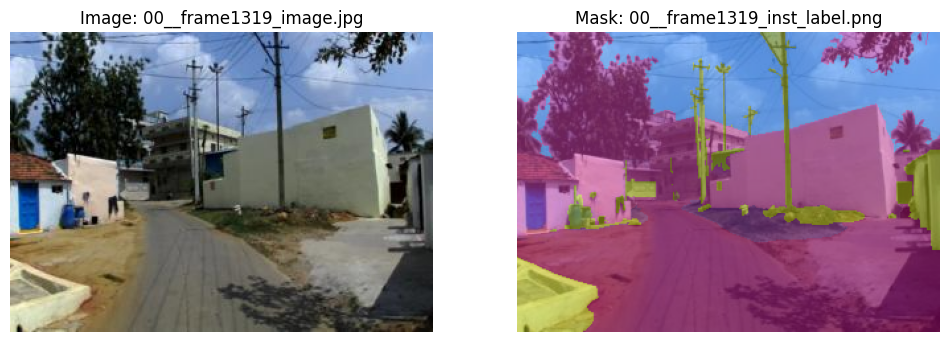

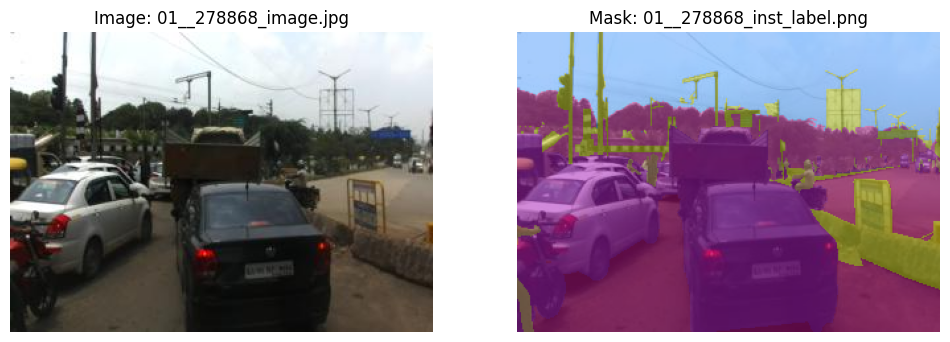

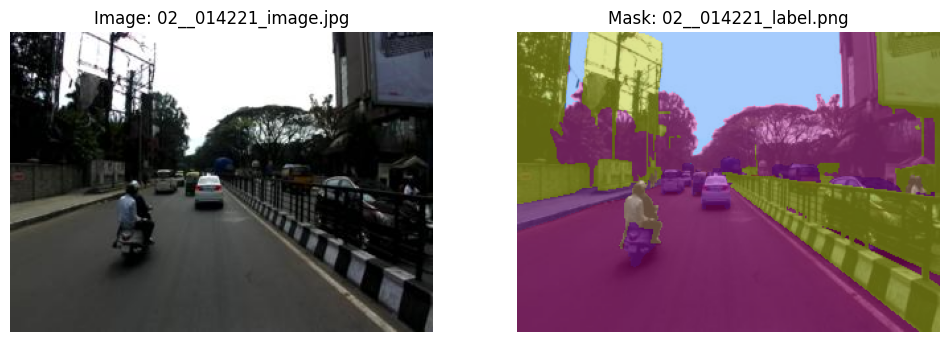

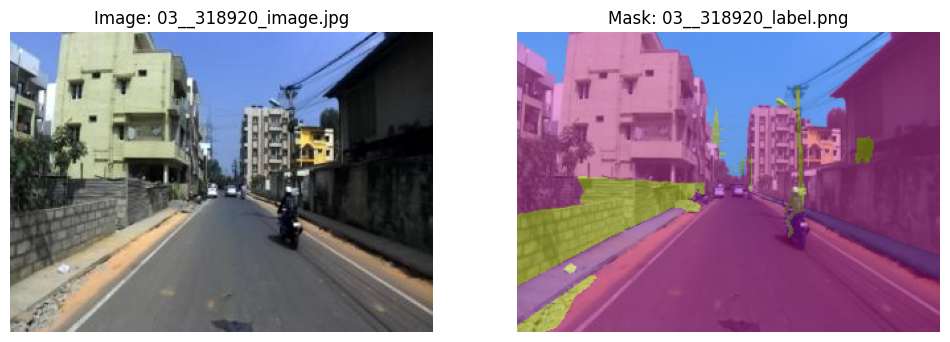

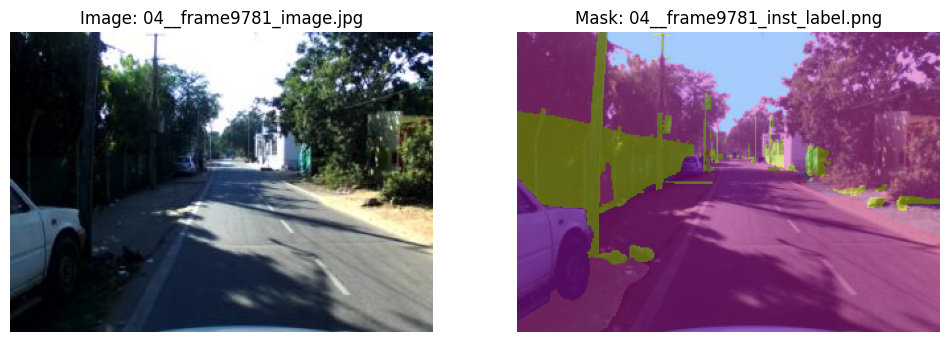

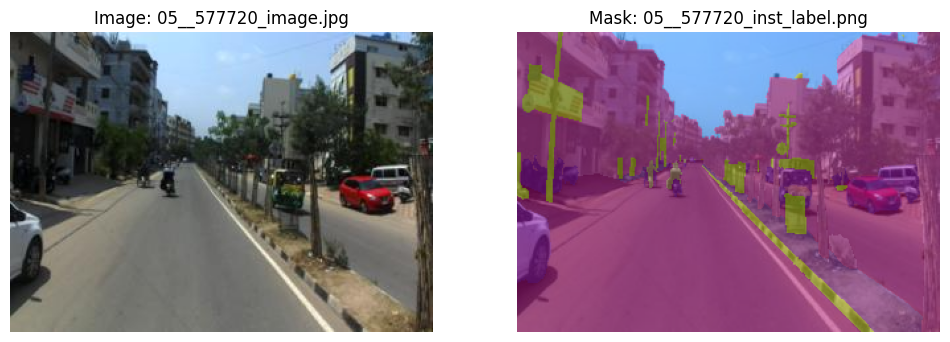

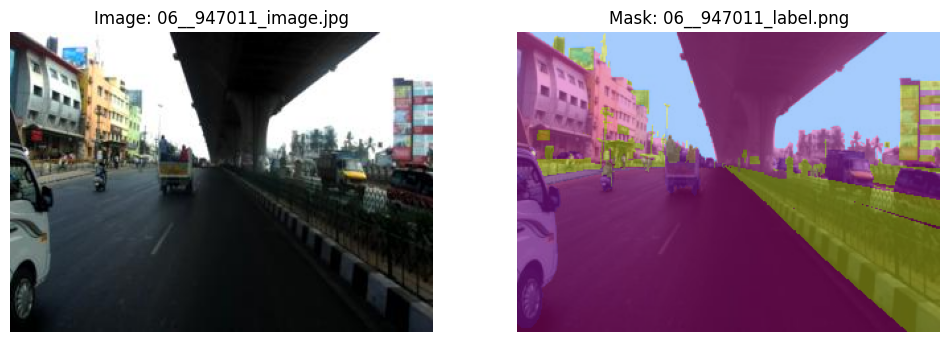

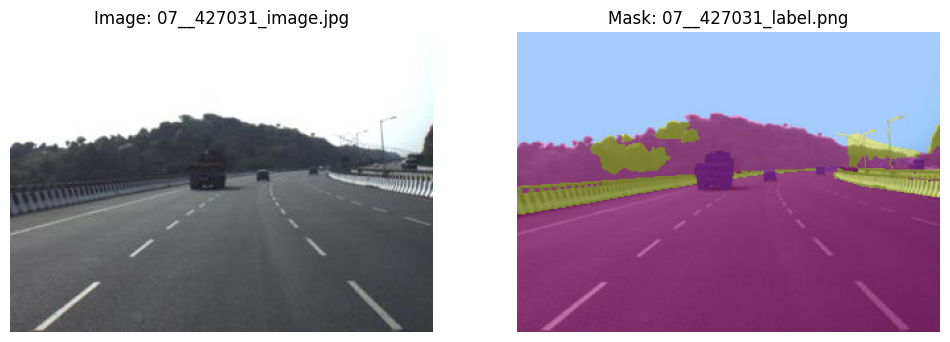

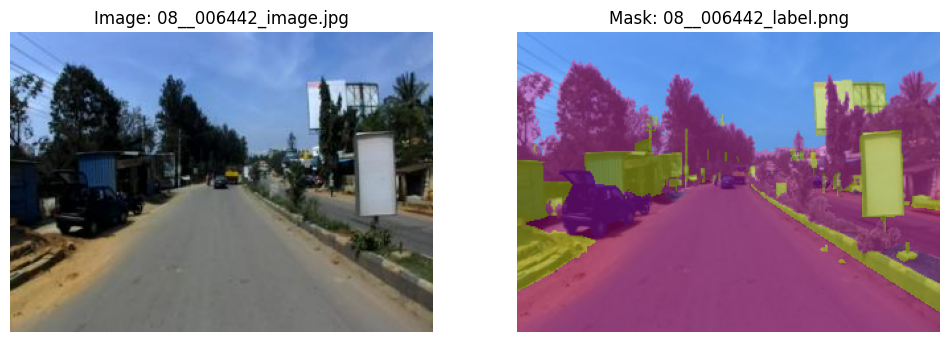

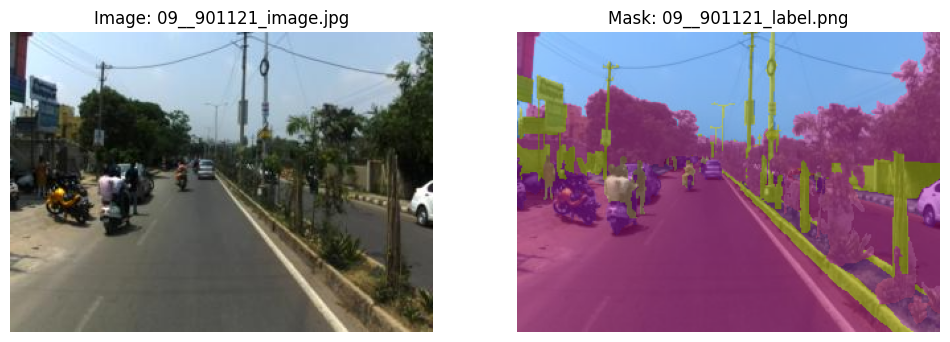

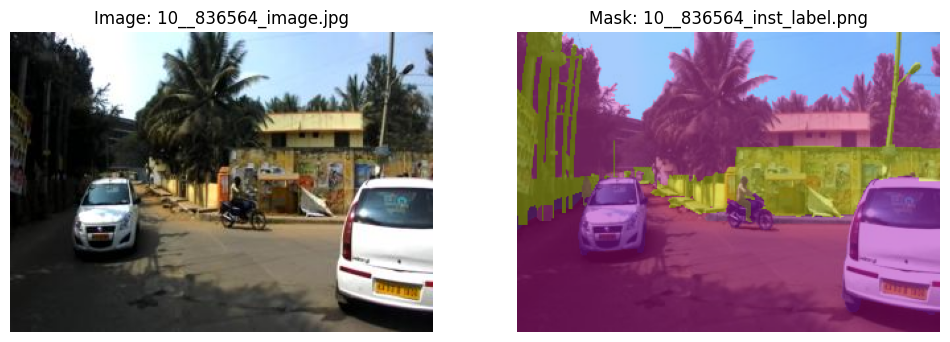

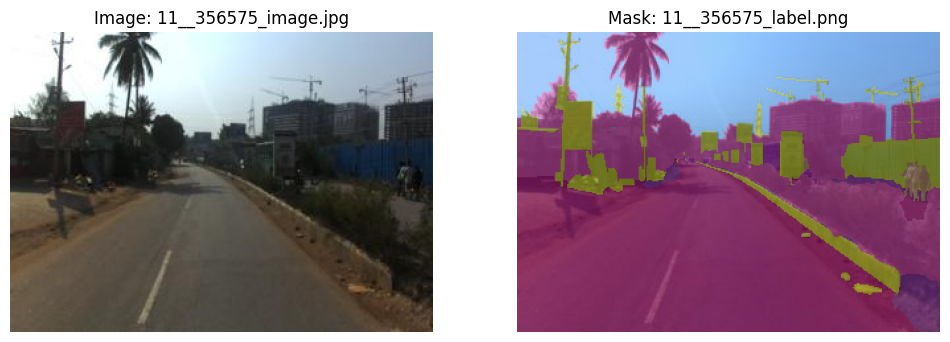

Preview complete. If overlays look correct, reply: 'pairs ok'.
If many masks were unmatched, reply: 'many unmatched' and paste the first few unmatched names printed above.


In [10]:
# Full fixed cell: pair IDD-Lite masks with images, copy sample pairs, and visualize overlays
# Handles mask label values >=256 safely by mapping them into 0..255 before coloring.
from pathlib import Path
import re, random, shutil, cv2, numpy as np, matplotlib.pyplot as plt

# ---------- CONFIG: your dataset root ----------
DATA_ROOT = Path(r"E:\projects\adas_local\data\idd_lite\idd-lite\idd20k_lite")
LEFT = DATA_ROOT / "leftImg8bit"
GT   = DATA_ROOT / "gtFine"

# ---------- sanity checks ----------
if not DATA_ROOT.exists():
    raise SystemExit(f"DATA_ROOT not found: {DATA_ROOT}")
if not LEFT.exists() or not GT.exists():
    raise SystemExit(f"Expected folders missing under DATA_ROOT.\nFound: {list(DATA_ROOT.iterdir())}")

# ---------- gather files ----------
img_paths  = list(LEFT.rglob("*.jpg")) + list(LEFT.rglob("*.png")) + list(LEFT.rglob("*.jpeg"))
mask_paths = list(GT.rglob("*_label.png")) + list(GT.rglob("*_labelIds.png")) + list(GT.rglob("*_labelTrainIds.png")) + list(GT.rglob("*_color.png")) + list(GT.rglob("*_inst.png")) + list(GT.rglob("*.png"))

# deduplicate mask_paths while preserving order
seen = set(); masks = []
for p in mask_paths:
    if p not in seen:
        masks.append(p); seen.add(p)
mask_paths = masks

print(f"Found {len(img_paths)} image files under leftImg8bit")
print(f"Found {len(mask_paths)} candidate mask files under gtFine")

# ---------- build index of images by numeric stems (4-8 digit chunks) ----------
img_index = {}
for ip in img_paths:
    stem = ip.stem
    nums = re.findall(r"\d{4,8}", stem)
    if not nums:
        img_index.setdefault(stem, []).append(ip)
    else:
        for n in nums:
            img_index.setdefault(n, []).append(ip)

# ---------- helper to extract numeric stems from mask filename ----------
def numeric_stems_from_mask(p: Path):
    name = p.stem
    nums = re.findall(r"\d{4,8}", name)
    if nums:
        return nums
    nums = re.findall(r"\d+", name)
    return nums

# ---------- pair masks to images ----------
pairs = []
unmatched_masks = []
for m in mask_paths:
    stems = numeric_stems_from_mask(m)
    found = None
    for st in stems:
        if st in img_index:
            candidates = img_index[st]
            try:
                split = m.parts[-3]
                city  = m.parts[-2]
                for c in candidates:
                    if split in c.parts and city in c.parts:
                        found = c
                        break
                if not found:
                    for c in candidates:
                        if split in c.parts:
                            found = c
                            break
            except Exception:
                pass
            if not found:
                found = candidates[0]
            break
    if found:
        pairs.append((m, found))
    else:
        unmatched_masks.append(m)

print(f"Paired masks -> images: {len(pairs)}")
print(f"Unmatched masks: {len(unmatched_masks)}")

if unmatched_masks:
    print("\nFirst 10 unmatched masks (for inspection):")
    for m in unmatched_masks[:10]:
        print(" ", m.relative_to(DATA_ROOT))

# ---------- create preview folder and copy up to 12 sample pairs ----------
preview = Path.cwd() / "idd_preview_pairs"
if preview.exists():
    shutil.rmtree(preview)
preview.mkdir(parents=True, exist_ok=True)
(preview / "images").mkdir(exist_ok=True)
(preview / "masks").mkdir(exist_ok=True)

num_samples = min(12, len(pairs))
if num_samples == 0:
    raise SystemExit("No pairs found to preview. Check the 'unmatched masks' printed above.")
sample_pairs = random.sample(pairs, num_samples)

for i, (m, img) in enumerate(sample_pairs):
    img_dst  = preview / "images" / f"{i:02d}__{img.name}"
    mask_dst = preview / "masks"  / f"{i:02d}__{m.name}"
    shutil.copy(img, img_dst)
    shutil.copy(m, mask_dst)

print(f"\nCopied {num_samples} sample pairs to: {preview}")

# ---------- helper to read mask into label array ----------
def read_mask_to_label(mask_path, target_shape):
    m = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED)
    if m is None:
        return None
    # if 3-channel color mask, reduce to single channel by using first channel (approx)
    if m.ndim == 3:
        m = m[:, :, 0]
    # resize if needed (nearest)
    if m.shape[:2] != (target_shape[0], target_shape[1]):
        m = cv2.resize(m, (target_shape[1], target_shape[0]), interpolation=cv2.INTER_NEAREST)
    return m

# ---------- visualize preview pairs safely (map labels into 0..255) ----------
cmap = np.random.RandomState(0).randint(0, 255, (256, 3), dtype=np.uint8)

for i in range(num_samples):
    img_p  = preview / "images" / f"{i:02d}__{sample_pairs[i][1].name}"
    mask_p = preview / "masks"  / f"{i:02d}__{sample_pairs[i][0].name}"
    img = cv2.cvtColor(cv2.imread(str(img_p)), cv2.COLOR_BGR2RGB)
    mask = read_mask_to_label(mask_p, img.shape)
    if mask is None:
        print("Failed to read mask:", mask_p)
        continue

    # --- SAFE mapping: ensure integer type and map into 0..255 before indexing cmap ---
    mask_int = mask.astype(np.int32)
    mask_mod = np.mod(mask_int, 256).astype(np.uint8)   # values now 0..255
    color_mask = cmap[mask_mod]                         # safe indexing
    overlay = (0.5 * img + 0.5 * color_mask).astype(np.uint8)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Image: {img_p.name}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f"Mask: {mask_p.name}")
    plt.axis("off")
    plt.show()

print("Preview complete. If overlays look correct, reply: 'pairs ok'.\nIf many masks were unmatched, reply: 'many unmatched' and paste the first few unmatched names printed above.")


In [14]:
# Convert IDD-Lite (Cityscapes-style) -> YOLOv8-seg layout and write data.yaml
# Kernel: Python (adas)

from pathlib import Path
import re, shutil, os
from tqdm import tqdm

# ---------- CONFIG: change if needed ----------
ROOT = Path(r"E:\projects\adas_local\data\idd_lite\idd-lite\idd20k_lite")
OUT_ROOT = Path(r"E:\projects\adas_local\data\idd_lite_yoloseg")  # where new dataset will be created

left = ROOT / "leftImg8bit"
gt   = ROOT / "gtFine"

splits = ["train", "val"]   # we'll prepare train & val (test can be added similarly)

# IDD-Lite class names (7 classes) and number of classes
# Source: IDD-Lite / community notes — mapping level3-lite
names = {
    0: "drivable",
    1: "non_drivable",
    2: "living_thing",
    3: "vehicle_2w_auto_large",   # 2-wheeler / auto-rickshaw / large-vehicle grouped
    4: "barrier_structure",
    5: "construction",
    6: "vegetation_sky"
}
nc = len(names)

# ---------- helper to extract numeric stems ----------
def stems_from_name(p: Path):
    s = p.stem
    nums = re.findall(r"\d{4,8}", s)
    if nums:
        return nums
    # fallback to any digits
    return re.findall(r"\d+", s)

# ---------- build an image index by numeric stems ----------
img_index = {}
all_images = []
for split in splits:
    for img in (left / split).rglob("*.jpg"):
        all_images.append(img)
        nums = stems_from_name(img)
        for n in nums:
            img_index.setdefault(n, []).append(img)
    # also include png just in case
    for img in (left / split).rglob("*.png"):
        if img not in all_images:
            all_images.append(img)
            nums = stems_from_name(img)
            for n in nums:
                img_index.setdefault(n, []).append(img)

print(f"Found {len(all_images)} images across splits {splits}")

# ---------- gather mask files ----------
mask_patterns = ["*_label.png","*_labelIds.png","*_labelTrainIds.png","*_color.png","*_inst_label.png","*label.png"]
mask_files = []
for split in splits:
    for pat in mask_patterns:
        mask_files.extend(list((gt / split).rglob(pat)))
# dedupe
mask_files = list(dict.fromkeys(mask_files))
print(f"Found {len(mask_files)} mask files under gtFine/{splits}")

# ---------- pair masks -> images ----------
pairs_by_split = {s: [] for s in splits}
unmatched = []
for m in mask_files:
    stems = stems_from_name(m)
    found = None
    for st in stems:
        if st in img_index:
            # prefer same split/city match
            candidates = img_index[st]
            for c in candidates:
                try:
                    if m.parts[-3] in c.parts and m.parts[-2] in c.parts:
                        found = c
                        break
                except Exception:
                    pass
            if not found:
                found = candidates[0]
            break
    if found:
        split = m.parts[-3] if m.parts[-3] in splits else "train"
        pairs_by_split[split].append((found, m))
    else:
        unmatched.append(m)

print("Pairs found per split:")
for s in splits:
    print(f"  {s}: {len(pairs_by_split[s])} pairs")
print("Unmatched masks:", len(unmatched))
if unmatched:
    print("First 5 unmatched mask examples:", [u.name for u in unmatched[:5]])

# ---------- prepare output folders ----------
for sub in ["images", "labels"]:
    for s in splits:
        d = OUT_ROOT / sub / s
        d.mkdir(parents=True, exist_ok=True)

# ---------- copy pairs into new structure (images -> images/{split}, masks -> labels/{split}) ----------
copied = 0
for s in splits:
    for img_path, mask_path in tqdm(pairs_by_split[s], desc=f"Copying {s}"):
        # create destination filenames: keep original image filename,
        # label will be image stem + .png (yolov8-seg expects mask image with same stem)
        dst_img = OUT_ROOT / "images" / s / img_path.name
        dst_mask = OUT_ROOT / "labels" / s / (img_path.stem + ".png")

        # copy image (if already exists skip)
        if not dst_img.exists():
            shutil.copy2(img_path, dst_img)
        # read mask and convert if necessary to single-channel label image
        # We'll copy mask as-is but ensure it's saved as single-channel PNG
        if not dst_mask.exists():
            import numpy as np
            import cv2
            m = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED)
            if m is None:
                # fallback: copy raw file
                shutil.copy2(mask_path, dst_mask)
            else:
                # reduce to single channel if colored
                if m.ndim == 3:
                    m = m[:,:,0]
                # ensure dtype is uint8 (if larger labels exist keep as-is but map by modulus isn't necessary for training masks)
                if m.dtype != np.uint8:
                    # clip & convert (preserves label ids up to 255)
                    m = np.clip(m, 0, 255).astype("uint8")
                cv2.imwrite(str(dst_mask), m)
        copied += 1

print(f"Copied {copied} pairs into {OUT_ROOT}")

# ---------- write data.yaml (absolute Windows paths) ----------
data_yaml_path = OUT_ROOT / "data.yaml"
data_yaml = {
    "train": str((OUT_ROOT / "images" / "train").resolve()),
    "val":   str((OUT_ROOT / "images" / "val").resolve()),
    "nc": nc,
    "names": [names[i] for i in range(nc)]
}
import yaml
with open(data_yaml_path, "w") as f:
    yaml.safe_dump(data_yaml, f)

print("Wrote data.yaml to:", data_yaml_path)
print(open(data_yaml_path).read())

# ---------- quick verification counts ----------
for s in splits:
    imgs = list((OUT_ROOT / "images" / s).glob("*"))
    labels = list((OUT_ROOT / "labels" / s).glob("*"))
    print(f"OUT {s}: {len(imgs)} images, {len(labels)} masks")


Found 1607 images across splits ['train', 'val']
Found 3214 mask files under gtFine/['train', 'val']
Pairs found per split:
  train: 2806 pairs
  val: 408 pairs
Unmatched masks: 0


Copying val: 100%|██████████| 408/408 [00:00<00:00, 6386.48it/s]

Copied 3214 pairs into E:\projects\adas_local\data\idd_lite_yoloseg
Wrote data.yaml to: E:\projects\adas_local\data\idd_lite_yoloseg\data.yaml
names:
- drivable
- non_drivable
- living_thing
- vehicle_2w_auto_large
- barrier_structure
- construction
- vegetation_sky
nc: 7
train: E:\projects\adas_local\data\idd_lite_yoloseg\images\train
val: E:\projects\adas_local\data\idd_lite_yoloseg\images\val

OUT train: 1380 images, 1380 masks
OUT val: 204 images, 204 masks


In [20]:
# Notebook cell — start YOLOv8-seg training (same as terminal command)
import os
os.environ['PYTHONWARNINGS'] = 'ignore'
python -m ultralytics train model=yolov8n-seg.pt data=E:/projects/adas_local/data/idd_lite_yoloseg/data.yaml epochs=30 imgsz=640 batch=8 project=projects/idas_lite_seg name=run_yolov8n_seg



SyntaxError: invalid syntax (1011915849.py, line 4)